In [1]:
import qutip as q
import numpy as np
import scipy as sy
import time
import random as random
from timeit import default_timer as timer
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.integrate import odeint, complex_ode, ode
import latex

In [2]:
##Functions to implement the influence martingale
def mu_cont(tlist,args): # compute the continuous part of the martingale evolution
    s=np.ones(len(tlist))
    ss=0
    for jj in range(1,len(tlist)):
        # We  compute the time integral for every interval and sum them together
        ss +=sy.integrate.quad(lambda t: (Minimal_Rate_times2(t,None)) *8,tlist[jj-1], tlist[jj])[0]
        s[jj] = np.exp(ss)
    return s

def calc(t,sig,args): #compute contribution for an individual jump
    if sig < 12:
        s = 1 - (Minimal_Rate_times2(t,None)) / Rate_and_Ops[int(sig)][1]
    else:
        s = 1
    return s

def mu_jump(J_list,J_which,args): #Function to compute the jump contributions to the martingale
    #Compute a vector with factors due to jumps
    s = np.zeros(len(J_list))
    for j in range(0,len(J_list)):
        s[j] = calc(J_list[j], J_which[j], args)
    
    #The vector s may contain several jumps that happened during the same time interval [tlist[j-1],tlist[j]]. All jumps in this time interval should be accounted for at time tlist[j].
    #The vector S will be the actual output, where this is taken into account.
    index = np.zeros(len(J_list))
    S = np.ones(len(tlist))
    for jj in range(0,len(J_list)):
        #Index contains the closest time in tlist to which the jump happened. however if t_jump>tlist[index[jj]] we need to shift the index to jj+1 
        index[jj] = np.argmin(np.abs(tlist-J_list[jj]))
        if tlist[index[jj].astype(int)] - J_list[jj] <0:
            index[jj] += 1
    #Combine all elememts s to the right places index in S
    for j in range(0,len(index)):
            S[index[j].astype(int):] *= s[j]
    return S

In [3]:
ntraj = 10000# number of MC trajectories\

#define the initial and final times
tf=50
ti=0
tlist = np.linspace(0,tf,200)

#Physical parameters of the system
Gamma = 0.001
J=1
h=1
gam = 0.25
beta = 1
om = 1
C = 2*Gamma

#Initial state
psi0 = 1/4 * q.tensor(q.basis(2,0)+q.basis(2,1),q.basis(2,0)+q.basis(2,1),q.basis(2,0)+q.basis(2,1),q.basis(2,0)+q.basis(2,1))

In [4]:
#Define the observables for all 4 sites
sx1 = q.tensor(q.sigmax(),q.qeye(2),q.qeye(2),q.qeye(2))
sy1 = q.tensor(q.sigmay(),q.qeye(2),q.qeye(2),q.qeye(2))
sz1 = q.tensor(q.sigmaz(),q.qeye(2),q.qeye(2),q.qeye(2))
sp1 = q.tensor(q.sigmap(),q.qeye(2),q.qeye(2),q.qeye(2))
sm1 = q.tensor(q.sigmam(),q.qeye(2),q.qeye(2),q.qeye(2))

sx2 = q.tensor(q.qeye(2),q.sigmax(),q.qeye(2),q.qeye(2))
sy2 = q.tensor(q.qeye(2),q.sigmay(),q.qeye(2),q.qeye(2))
sz2 = q.tensor(q.qeye(2),q.sigmaz(),q.qeye(2),q.qeye(2))
sp2 = q.tensor(q.qeye(2),q.sigmap(),q.qeye(2),q.qeye(2))
sm2 = q.tensor(q.qeye(2),q.sigmam(),q.qeye(2),q.qeye(2))

sx3 = q.tensor(q.qeye(2),q.qeye(2),q.sigmax(),q.qeye(2))
sy3 = q.tensor(q.qeye(2),q.qeye(2),q.sigmay(),q.qeye(2))
sz3 = q.tensor(q.qeye(2),q.qeye(2),q.sigmaz(),q.qeye(2))
sp3 = q.tensor(q.qeye(2),q.qeye(2),q.sigmap(),q.qeye(2))
sm3 = q.tensor(q.qeye(2),q.qeye(2),q.sigmam(),q.qeye(2))

sx4 = q.tensor(q.qeye(2),q.qeye(2),q.qeye(2),q.sigmax())
sy4 = q.tensor(q.qeye(2),q.qeye(2),q.qeye(2),q.sigmay())
sz4 = q.tensor(q.qeye(2),q.qeye(2),q.qeye(2),q.sigmaz())
sp4 = q.tensor(q.qeye(2),q.qeye(2),q.qeye(2),q.sigmap())
sm4 = q.tensor(q.qeye(2),q.qeye(2),q.qeye(2),q.sigmam())

In [5]:
H = J * ((1+gam)*(sx1*sx2 + sx2*sx3 + sx3*sx4 + sx4*sx1)+(1-gam)*(sy1*sy2 + sy2*sy3 + sy3*sy4 + sy4*sy1) 
        +(sz1*sz2 + sz2*sz3 + sz3*sz4 + sz4*sz1)) - gam*h*(sy1+sy2+sy3+sy4)

In [6]:
c_ops = []
c_ops.append(sm1*np.sqrt(Gamma))
c_ops.append(sm2*np.sqrt(Gamma))
c_ops.append(sm3*np.sqrt(Gamma))
c_ops.append(sm4*np.sqrt(Gamma))

c_ops.append(sz1*np.sqrt(Gamma))
c_ops.append(sz2*np.sqrt(Gamma))
c_ops.append(sz3*np.sqrt(Gamma))
c_ops.append(sz4*np.sqrt(Gamma))

In [7]:
d_ops = []
d_ops.append(sm1*np.sqrt(Gamma))
d_ops.append(sm2*np.sqrt(Gamma))
d_ops.append(sm3*np.sqrt(Gamma))
d_ops.append(sm4*np.sqrt(Gamma))

d_ops.append(sz1*np.sqrt(Gamma))
d_ops.append(sz2*np.sqrt(Gamma))
d_ops.append(sz3*np.sqrt(Gamma))
d_ops.append(sz4*np.sqrt(Gamma))

d_ops.append(sp1*np.sqrt(2*Gamma))
d_ops.append(sp2*np.sqrt(2*Gamma))
d_ops.append(sp3*np.sqrt(2*Gamma))
d_ops.append(sp4*np.sqrt(2*Gamma))

d_ops.append(sm1*np.sqrt(Gamma))
d_ops.append(sm2*np.sqrt(Gamma))
d_ops.append(sm3*np.sqrt(Gamma))
d_ops.append(sm4*np.sqrt(Gamma))

d_ops.append(sz1*np.sqrt(Gamma))
d_ops.append(sz2*np.sqrt(Gamma))
d_ops.append(sz3*np.sqrt(Gamma))
d_ops.append(sz4*np.sqrt(Gamma))

In [8]:
#Define a function and array for the influence martingale functions
def Minimal_Rate_times2(t,args):
    return C

Rate_and_Ops = []

Rate_and_Ops.append([sm1,Gamma])
Rate_and_Ops.append([sm2,Gamma])
Rate_and_Ops.append([sm3,Gamma])
Rate_and_Ops.append([sm4,Gamma])

Rate_and_Ops.append([sz1,Gamma])
Rate_and_Ops.append([sz2,Gamma])
Rate_and_Ops.append([sz3,Gamma])
Rate_and_Ops.append([sz4,Gamma])

Rate_and_Ops.append([sp1,2*Gamma])
Rate_and_Ops.append([sp2,2*Gamma])
Rate_and_Ops.append([sp3,2*Gamma])
Rate_and_Ops.append([sp4,2*Gamma])

In [9]:
e_ops = [sp1*sm1, sp2*sm2, sp3*sm3, sp4*sm4]

In [10]:
SESol=q.sesolve(H,psi0,tlist,e_ops)
MESol=q.mesolve(H,psi0,tlist,c_ops,e_ops)
SESol_st=q.sesolve(H,psi0,tlist)
MESol_st=q.mesolve(H,psi0,tlist,c_ops)
SESol2=q.sesolve(H,psi0,tlist,e_ops)
MESol2=q.mesolve(H,psi0,tlist,d_ops,e_ops)
SESol2_st=q.sesolve(H,psi0,tlist)
MESol2_st=q.mesolve(H,psi0,tlist,d_ops)

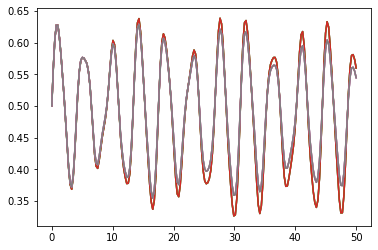

In [11]:
plt.plot(tlist,SESol.expect[0])
plt.plot(tlist,SESol.expect[1])
plt.plot(tlist,SESol.expect[2])
plt.plot(tlist,SESol.expect[3])

plt.plot(tlist,MESol.expect[0])
plt.plot(tlist,MESol.expect[1])
plt.plot(tlist,MESol.expect[2])
plt.plot(tlist,MESol.expect[3])

In [12]:
#Fidelity at the tf=50
q.fidelity(SESol_st.states[-1]*SESol_st.states[-1].dag(),MESol_st.states[-1])

0.8812653466002242

In [ ]:
#Get statistics for 10^6 trajectories
State6 = []
Tr6 = []

Mu = mu_cont(tlist,None)

for mm in range(0,len(tlist)):
    State6.append(0)
    Tr6.append(0)
    
opts = q.Options(average_expect = False)
for jj in range(0,100):
    MCSol00_st = q.mcsolve(H, psi0, tlist, d_ops, ntraj=10000, options = opts,progress_bar=None)  
    for j in range(0,10000):
        times = MCSol00_st.col_times[j]
        jumps = np.zeros(len(MCSol00_st.col_times[j]))
        jumps[:] = MCSol00_st.col_which[j]
        lala = mu_jump(times,jumps,None) * Mu 
        for kk in range(0,len(tlist)):
            Tr6[kk] += lala[kk] * (MCSol00_st.states[j][kk]*MCSol00_st.states[j][kk].dag()).tr()
            State6[kk] += lala[kk] * MCSol00_st.states[j][kk]*MCSol00_st.states[j][kk].dag()
        
        
        
        

In [ ]:
#Get statistics for 10^5 trajectories
State5 = []
Tr5 = []

Mu = mu_cont(tlist,None)

for mm in range(0,len(tlist)):
    State5.append(0)
    Tr5.append(0)
    
opts = q.Options(average_expect = False)
for jj in range(0,10):
    MCSol00_st = q.mcsolve(H, psi0, tlist, d_ops, ntraj=10000, options = opts,progress_bar=None)  
    for j in range(0,10000):
        times = MCSol00_st.col_times[j]
        jumps = np.zeros(len(MCSol00_st.col_times[j]))
        jumps[:] = MCSol00_st.col_which[j]
        lala = mu_jump(times,jumps,None) * Mu 
        for kk in range(0,len(tlist)):
            Tr5[kk] += lala[kk] * (MCSol00_st.states[j][kk]*MCSol00_st.states[j][kk].dag()).tr()
            State5[kk] += lala[kk] * MCSol00_st.states[j][kk]*MCSol00_st.states[j][kk].dag()
        

In [ ]:
#Get statistics for 10^4 trajectories
State2 = []
Tr2 = []

for mm in range(0,len(tlist)):
    State2.append(0)
    Tr2.append(0)
opts = q.Options(average_expect = False)

for j in range(0,10000):
    times = MCSol00_st.col_times[j]
    jumps = np.zeros(len(MCSol00_st.col_times[j]))
    jumps[:] = MCSol00_st.col_which[j]
    lala = mu_jump(times,jumps,None) * Mu 

    for kk in range(0,len(tlist)):
            Tr2[kk] += lala[kk] * (MCSol00_st.states[j][kk]*MCSol00_st.states[j][kk].dag()).tr()
            State2[kk] += lala[kk] * MCSol00_st.states[j][kk]*MCSol00_st.states[j][kk].dag()
            
            

In [24]:
#Fidelities with target state at the final time 
q.fidelity(SESol_st.states[-1]*SESol_st.states[-1].dag(),State2/Tr2)
q.fidelity(SESol_st.states[-1]*SESol_st.states[-1].dag(),State5/Tr5)
q.fidelity(SESol_st.states[-1]*SESol_st.states[-1].dag(),State6/Tr6)

TypeError: unsupported operand type(s) for /: 'list' and 'list'

In [19]:
Fid = np.zeros(len(tlist))
FidN = np.zeros(len(tlist))
FidN2 = np.zeros(len(tlist))
Fid5 = np.zeros(len(tlist))
Fid6 = np.zeros(len(tlist))
for kk in range(0,len(tlist)):
    Fid[kk] = q.fidelity(SESol_st.states[kk]*SESol_st.states[kk].dag(),State2[kk]/Tr2[kk])
    FidN[kk] = q.fidelity(SESol_st.states[kk]*SESol_st.states[kk].dag(),MESol_st.states[kk])
    FidN2[kk] = q.fidelity(SESol_st.states[kk]*SESol_st.states[kk].dag(),MESol2_st.states[kk])
    Fid5[kk] = q.fidelity(SESol_st.states[kk]*SESol_st.states[kk].dag(),State5[kk]/Tr5[kk])
    Fid6[kk] = q.fidelity(SESol_st.states[kk]*SESol_st.states[kk].dag(),State6[kk]/Tr6[kk])

0.37090266572723407
-1.2736021927583734
-1.7183099828356136
-2.5916435392834303


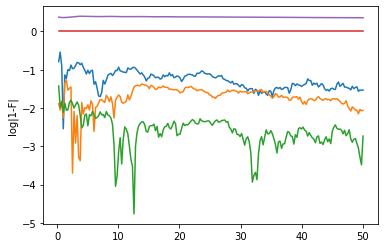

In [26]:
plt.plot(tlist[1:],np.log10(np.abs(1-Fid[1:]))-np.log10(np.abs(1-FidN[1:])))
plt.plot(tlist[1:],np.log10(np.abs(1-Fid5[1:]))-np.log10(np.abs(1-FidN[1:])))
plt.plot(tlist[1:],np.log10(np.abs(1-Fid6[1:]))-np.log10(np.abs(1-FidN[1:])))
plt.plot(tlist[1:],np.log10(np.abs(1-FidN[1:]))-np.log10(np.abs(1-FidN[1:])))
plt.plot(tlist[1:],np.log10(np.abs(1-FidN2[1:]))-np.log10(np.abs(1-FidN[1:])))
plt.ylabel('log|1-F|')
print((np.log10(np.abs(1-FidN2[1:]))-np.log10(np.abs(1-FidN[1:]))).sum()/200)
print((np.log10(np.abs(1-Fid[1:]))-np.log10(np.abs(1-FidN[1:]))).sum()/200)
print((np.log10(np.abs(1-Fid5[1:]))-np.log10(np.abs(1-FidN[1:]))).sum()/200)
print((np.log10(np.abs(1-Fid6[1:]))-np.log10(np.abs(1-FidN[1:]))).sum()/200)

## Error Mitigation with Errors in rates and operators

In [ ]:
#Define a function that new jump operators sm1+ERRJ and rates Gamma+error_Rates[J]
def D_OPS(error_Ops,error_Rates):
    
    ERR1 = q.tensor(q.Qobj(error_Ops[0]),q.qeye(2),q.qeye(2),q.qeye(2))
    ERR2 = q.tensor(q.qeye(2),q.Qobj(error_Ops[1]),q.qeye(2),q.qeye(2))
    ERR3 = q.tensor(q.qeye(2),q.qeye(2),q.Qobj(error_Ops[2]),q.qeye(2))
    ERR4 = q.tensor(q.qeye(2),q.qeye(2),q.qeye(2),q.Qobj(error_Ops[3]))
    
    ERR5 = q.tensor(q.Qobj(error_Ops[4]),q.qeye(2),q.qeye(2),q.qeye(2))
    ERR6 = q.tensor(q.qeye(2),q.Qobj(error_Ops[5]),q.qeye(2),q.qeye(2))
    ERR7 = q.tensor(q.qeye(2),q.qeye(2),q.Qobj(error_Ops[6]),q.qeye(2))
    ERR8 = q.tensor(q.qeye(2),q.qeye(2),q.qeye(2),q.Qobj(error_Ops[7]))
    
    
    c_ops_err = []
    
    c_ops_err.append((sm1+ERR1)*np.sqrt(Gamma+error_Rates[0]))
    c_ops_err.append((sm2+ERR2)*np.sqrt(Gamma+error_Rates[1]))
    c_ops_err.append((sm3+ERR3)*np.sqrt(Gamma+error_Rates[2]))
    c_ops_err.append((sm4+ERR4)*np.sqrt(Gamma+error_Rates[3]))

    c_ops_err.append((sz1+ERR5)*np.sqrt(Gamma+error_Rates[4]))
    c_ops_err.append((sz2+ERR6)*np.sqrt(Gamma+error_Rates[5]))
    c_ops_err.append((sz3+ERR7)*np.sqrt(Gamma+error_Rates[6]))
    c_ops_err.append((sz4+ERR8)*np.sqrt(Gamma+error_Rates[7]))
    
    
    d_ops_err = []
    d_ops_err.append(sm1*np.sqrt(Gamma))
    d_ops_err.append(sm2*np.sqrt(Gamma))
    d_ops_err.append(sm3*np.sqrt(Gamma))
    d_ops_err.append(sm4*np.sqrt(Gamma))

    d_ops_err.append(sz1*np.sqrt(Gamma))
    d_ops_err.append(sz2*np.sqrt(Gamma))
    d_ops_err.append(sz3*np.sqrt(Gamma))
    d_ops_err.append(sz4*np.sqrt(Gamma))

    d_ops_err.append(sp1*np.sqrt(2*Gamma))
    d_ops_err.append(sp2*np.sqrt(2*Gamma))
    d_ops_err.append(sp3*np.sqrt(2*Gamma))
    d_ops_err.append(sp4*np.sqrt(2*Gamma))

    d_ops_err.append((sm1+ERR1)*np.sqrt(Gamma+error_Rates[0]))
    d_ops_err.append((sm2+ERR2)*np.sqrt(Gamma+error_Rates[1]))
    d_ops_err.append((sm3+ERR3)*np.sqrt(Gamma+error_Rates[2]))
    d_ops_err.append((sm4+ERR4)*np.sqrt(Gamma+error_Rates[3]))

    d_ops_err.append((sz1+ERR5)*np.sqrt(Gamma+error_Rates[4]))
    d_ops_err.append((sz2+ERR6)*np.sqrt(Gamma+error_Rates[5]))
    d_ops_err.append((sz3+ERR7)*np.sqrt(Gamma+error_Rates[6]))
    d_ops_err.append((sz4+ERR8)*np.sqrt(Gamma+error_Rates[7]))
    
    
    Rate_and_Ops_err = []

    Rate_and_Ops_err.append([sm1,Gamma])
    Rate_and_Ops_err.append([sm2,Gamma])
    Rate_and_Ops_err.append([sm3,Gamma])
    Rate_and_Ops_err.append([sm4,Gamma])

    Rate_and_Ops_err.append([sz1,Gamma])
    Rate_and_Ops_err.append([sz2,Gamma])
    Rate_and_Ops_err.append([sz3,Gamma])
    Rate_and_Ops_err.append([sz4,Gamma])

    Rate_and_Ops_err.append([sp1,2*Gamma])
    Rate_and_Ops_err.append([sp2,2*Gamma])
    Rate_and_Ops_err.append([sp3,2*Gamma])
    Rate_and_Ops_err.append([sp4,2*Gamma])
    
    return c_ops_err, d_ops_err, Rate_and_Ops_err

In [ ]:
#Consider the two types of errors described in the manuscript
Noise_Str = np.array([0,0.2,0.4,0.6,0.8,1]) * Gamma
Op_Str = np.array([0,0.2,0.4,0.6,0.8,1])


opts = q.Options(average_expect = False)
init00 = q.Qobj(np.array([1,0]))

M=10
FidelityJ = np.zeros([len(Op_Str),len(Noise_Str)])
FidelityJN = np.zeros([len(Op_Str),len(Noise_Str)])
FidelityJN_all = np.zeros([M,len(Op_Str),len(Noise_Str)])
FidelityJ_all = np.zeros([M,len(Op_Str),len(Noise_Str)])

Mu = mu_cont(tlist,None)

for mm in range(0,M):
    print(mm)
    for ll in range(0,len(Op_Str)):
        
        op_Str= Op_Str[ll]
        
        for kk in range(0,len(Noise_Str)):
            
            State = 0 
            Tr = 0
            noise_Str = Noise_Str[kk]            
            error_Ops = op_Str * np.random.random([8,2,2])
            error_Rates = noise_Str * (np.random.random([8]))

            c_ops_err, d_ops_err, Rate_and_Ops_err = D_OPS(error_Ops,error_Rates)
            
            MESolR = q.mesolve(H, psi0, tlist, c_ops_err)
            MCSol00R = q.mcsolve(H, psi0, tlist, d_ops_err, ntraj=10000, options = opts,progress_bar=None)
            for j in range(0,ntraj):
                times = MCSol00R.col_times[j]
                jumps = np.zeros(len(MCSol00R.col_times[j]))
                jumps[:] = MCSol00R.col_which[j]
                lala = mu_jump(times,jumps,None) * Mu 

                Tr += lala[-1] * (MCSol00R.states[j][-1]*MCSol00R.states[j][-1].dag()).tr()
                State += lala[-1] * MCSol00R.states[j][-1]*MCSol00R.states[j][-1].dag()
                
            del MCSol00R
            
            fid = q.fidelity(State/Tr,SESol_st.states[-1]*SESol_st.states[-1].dag())
            fidN = q.fidelity(MESolR.states[-1],SESol_st.states[-1]*SESol_st.states[-1].dag())
            
            FidelityJ[ll,kk] += fid
            FidelityJN[ll,kk] += np.log10(np.abs(1-fid))-np.log10(np.abs(1-fidN))
            FidelityJN_all[mm,ll,kk] = np.log10(np.abs(1-fid))-np.log10(np.abs(1-fidN))
            FidelityJ_all[mm,ll,kk] = fid

In [ ]:
#make a fancy heat map with the errors
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
}) 
fig1, ax2 = plt.subplots()

levels = np.linspace(-2,0, 101)
levels2 = [-0.9254225111725768,0]
CS = ax2.contourf(Noise_Str/Gamma,Op_Str,FidelityJN/10,levels,cmap='plasma')
cbar = plt.colorbar(CS, ticks = [-2,-1.6,-1.2,-.8,-.4,0])
#cbar = plt.colorbar(CS,norm=colors.LogNorm())
cbar.set_ticklabels(['$10^{-2}$','$10^{-1.6}$','$10^{-1.2}$','$10^{-0.8}$','$10^{-0.4}$','$10^{0}$'])
cbar.ax.tick_params(labelsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathcal{E}_R$',fontsize=14)
plt.ylabel('$\mathcal{E}_L$',fontsize=14)
#CS2 = ax2.contour(Noise_Str/Gamma,Op_Str,FidelityJN/10,levels=levels2,colors='black')
#cbar.add_lines(CS2)
plt.savefig('Errors_Rates.png', dpi=1000)
plt.savefig('Errors_Rates.pdf')

## Error mitigation with noise on jump times

In [ ]:
# Compute errors on the jump times as described in the manuscript
State5= []
Tr5 = []
Tr_Err5 = [] 
State_Err5 = []

Mu = mu_cont(tlist,None)

noise_strength = np.linspace(0,1,50)*Gamma**-1

for mm in range(0,len(tlist)):
    State5.append(0)
    Tr5.append(0)
for mm in range(0,len(noise_strength)):
    Tr_Err5.append(0)
    State_Err5.append(0)

M = 10

State_Err_all5 = []
for mm in range(0,len(noise_strength)*10):
    State_Err_all5.append(0)




opts = q.Options(average_expect = False)
for jj in range(0,10):
    print(jj)
    MCSol00_st = q.mcsolve(H, psi0, tlist, d_ops, ntraj=10000, options = opts,progress_bar=None) 
    
    for j in range(0,10000):
        times = MCSol00_st.col_times[j]
        jumps = np.zeros(len(MCSol00_st.col_times[j]))
        jumps[:] = MCSol00_st.col_which[j]
        lala = mu_jump(times,jumps,None) * Mu 
        for kk in range(0,len(tlist)):
            Tr5[kk] += lala[kk] * (MCSol00_st.states[j][kk]*MCSol00_st.states[j][kk].dag()).tr()
            State5[kk] += lala[kk] * MCSol00_st.states[j][kk]*MCSol00_st.states[j][kk].dag()
        
    for mm in range(0,10):
        for kk in range(0,len(noise_strength)):
            strength = noise_strength[kk]
            for j in range(0,ntraj):
                if len(MCSol00_st.col_times[j]) > 0:
                    times = np.zeros(len(MCSol00_st.col_times[j]))
                    jumps = np.zeros(len(MCSol00_st.col_times[j]))
                    jumps[:] = MCSol00_st.col_which[j]
                    for jj in range(0,len(MCSol00_st.col_times[j])):
                        times[jj] = max(MCSol00_st.col_times[j][jj]+strength*(np.random.random(1)-0.5),0)

                else:
                    times = MCSol00_st.col_times[j]
                    jumps = np.zeros(len(MCSol00_st.col_times[j]))
                    jumps[:] = MCSol00_st.col_which[j]
                lala = mu_jump(times,jumps,None) * Mu 

                Tr_Err5[kk] += lala[-1] * (MCSol00_st.states[j][-1]*MCSol00_st.states[j][-1].dag()).tr()
                State_Err5[kk] += lala[-1] * MCSol00_st.states[j][-1]*MCSol00_st.states[j][-1].dag()        
                State_Err_all5[int(mm*len(noise_strength)+kk)] += lala[-1] * MCSol00_st.states[j][-1]*MCSol00_st.states[j][-1].dag() 
    del MCSol00_st

In [ ]:
# Compute the fidelity 
FidErr5 = np.zeros(len(noise_strength))
for mm in range(0,10):
    for kk in range(0,len(noise_strength)):
        FidErr5[kk] += np.log10(np.abs(1-q.fidelity(State_Err_all5[int(mm*len(noise_strength)+kk)]/State_Err_all5[int(mm*len(noise_strength)+kk)].tr(),SESol_st.states[-1]*SESol_st.states[-1].dag())))
        

In [ ]:
#Plot the results
plt.plot(noise_strength/1000,FidErr5/10)
plt.plot(noise_strength/1000,np.log10(1-0.8812653466002242) + np.zeros(len(noise_strength)))
plt.plot(noise_strength/1000,np.log10(1-0.7319465418415538) + np.zeros(len(noise_strength)))
